# 08.5a: Cluster Dynamics Analysis

**Analyze black hole formation, fission, and evaporation using adjacency graphs**

We define tokens as **quantization-adjacent** if their Chebyshev distance is less than 2× the bfloat16 unit-in-last-place (ULP) at scale ~1:

$$d_\infty(\mathbf{u}, \mathbf{v}) < 2 \times 2^{-7} \approx 0.015625$$

This threshold captures tokens that are "close enough that bfloat16 quantization noise could make them identical."

## Questions We're Answering

1. **Black hole population:** How many duplicate tokens exist at each step?
2. **Adjacency graph structure:** How many connected components? How big is the largest?
3. **Who's in the black hole?** Which token IDs are clustered together?
4. **Near-misses:** Are there small clusters of 2-5 tokens that are quantization-close but not identical?

## Parameters

In [28]:
# Input: pre-computed data
DATA_DIR = "../data/embeddings_128vocab_qweninit"  # or embeddings_128vocab_qweninit
GEOMETRIC_FILE = "geometric_time_series.safetensors"
DISTANCES_FILE = "pairwise_distances.safetensors"

# Adjacency threshold (2× ULP at scale ~1)
ADJACENCY_THRESHOLD = 2 * (2 ** -7)  # ≈ 0.015625

# Snapshots to analyze in detail
KEY_SNAPSHOTS = [0, 100, 500, 5000]

# Training run parameters
VOCAB_SIZE = 128
EXPECTED_STEPS = 5001

RANDOM_SEED = 42

## Imports

In [29]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict, Counter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Load Data

In [30]:
data_dir = Path(DATA_DIR)

print(f"Loading data from: {data_dir}\n")

# Load geometric time series
geometric_path = data_dir / GEOMETRIC_FILE
geometric_data = load_file(geometric_path)

steps = geometric_data['steps']
n_duplicate_tokens = geometric_data['n_duplicate_tokens']
n_unique_vectors = geometric_data['n_unique_vectors']
n_singularity_groups = geometric_data['n_singularity_groups']

print(f"✓ Loaded geometric time series: {len(steps):,} snapshots")

# Load pairwise distances
distances_path = data_dir / DISTANCES_FILE
distances_data = load_file(distances_path)

chebyshev_distances = distances_data['chebyshev_distances']
euclidean_distances = distances_data['euclidean_distances']

n_snapshots, vocab_size, _ = chebyshev_distances.shape

print(f"✓ Loaded pairwise distances: {chebyshev_distances.shape}")
print(f"  Chebyshev dtype: {chebyshev_distances.dtype}")
print(f"  Euclidean dtype: {euclidean_distances.dtype}")
print(f"  Memory: {(chebyshev_distances.numel() + euclidean_distances.numel()) * 4 / 1e6:.2f} MB")

if n_snapshots != EXPECTED_STEPS:
    print(f"\n⚠ WARNING: Snapshot count mismatch! Expected {EXPECTED_STEPS:,}, got {n_snapshots:,}")
else:
    print(f"\n✓ All data loaded successfully")

Loading data from: ../data/embeddings_128vocab_qweninit

✓ Loaded geometric time series: 5,001 snapshots
✓ Loaded pairwise distances: torch.Size([5001, 128, 128])
  Chebyshev dtype: torch.float32
  Euclidean dtype: torch.float32
  Memory: 655.49 MB

✓ All data loaded successfully


## Graph Analysis Helper Functions

Simple union-find (disjoint set) implementation for finding connected components.

In [31]:
class UnionFind:
    """Union-Find data structure for connected components."""
    
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n
    
    def find(self, x):
        """Find root of x with path compression."""
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    
    def union(self, x, y):
        """Merge components containing x and y."""
        root_x = self.find(x)
        root_y = self.find(y)
        
        if root_x == root_y:
            return
        
        # Union by rank
        if self.rank[root_x] < self.rank[root_y]:
            self.parent[root_x] = root_y
        elif self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_y] = root_x
            self.rank[root_x] += 1
    
    def get_components(self):
        """Return list of connected components (lists of node IDs)."""
        components = defaultdict(list)
        for i in range(len(self.parent)):
            root = self.find(i)
            components[root].append(i)
        return list(components.values())

def find_connected_components(adjacency_matrix, threshold):
    """Find connected components in adjacency graph.
    
    Args:
        adjacency_matrix: (N, N) distance matrix
        threshold: maximum distance for adjacency
    
    Returns:
        List of connected components (each is a list of token IDs)
    """
    n = adjacency_matrix.shape[0]
    uf = UnionFind(n)
    
    # Build edges (only upper triangle to avoid duplicates)
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i, j] < threshold:
                uf.union(i, j)
    
    return uf.get_components()

print("✓ Graph analysis functions defined")

✓ Graph analysis functions defined


## Compute Cluster Statistics

For each snapshot, find connected components and track statistics.

In [32]:
print(f"\nComputing cluster statistics...")
print(f"Adjacency threshold: {ADJACENCY_THRESHOLD:.6f}\n")

# Time series arrays
n_components = torch.zeros(n_snapshots, dtype=torch.long)
largest_component_size = torch.zeros(n_snapshots, dtype=torch.long)
n_isolated_tokens = torch.zeros(n_snapshots, dtype=torch.long)

# Store components for key snapshots
components_at_snapshots = {}

for i in tqdm(range(n_snapshots), desc="Processing snapshots"):
    # Get Chebyshev distance matrix for this snapshot
    dist_matrix = chebyshev_distances[i]
    
    # Find connected components
    components = find_connected_components(dist_matrix, ADJACENCY_THRESHOLD)
    
    # Sort by size (largest first)
    components = sorted(components, key=len, reverse=True)
    
    # Record statistics
    n_components[i] = len(components)
    largest_component_size[i] = len(components[0]) if components else 0
    n_isolated_tokens[i] = sum(1 for c in components if len(c) == 1)
    
    # Store components for key snapshots
    if i in KEY_SNAPSHOTS:
        components_at_snapshots[i] = components

print(f"\n✓ Computed cluster statistics for {n_snapshots:,} snapshots")


Computing cluster statistics...
Adjacency threshold: 0.015625



Processing snapshots:   0%|          | 0/5001 [00:00<?, ?it/s]


✓ Computed cluster statistics for 5,001 snapshots


## Summary Statistics

In [33]:
print(f"\n{'='*80}")
print("CLUSTER DYNAMICS SUMMARY")
print(f"{'='*80}\n")

print(f"Adjacency threshold: {ADJACENCY_THRESHOLD:.6f} (2× ULP at scale ~1)")
print(f"Total snapshots: {n_snapshots:,}")

print(f"\nInitial state (step 0):")
print(f"  Connected components: {n_components[0]}")
print(f"  Largest component: {largest_component_size[0]} tokens")
print(f"  Isolated tokens: {n_isolated_tokens[0]}")
print(f"  Duplicate tokens: {n_duplicate_tokens[0]}")

print(f"\nFinal state (step {n_snapshots - 1}):")
print(f"  Connected components: {n_components[-1]}")
print(f"  Largest component: {largest_component_size[-1]} tokens")
print(f"  Isolated tokens: {n_isolated_tokens[-1]}")
print(f"  Duplicate tokens: {n_duplicate_tokens[-1]}")

print(f"\n{'='*80}")


CLUSTER DYNAMICS SUMMARY

Adjacency threshold: 0.015625 (2× ULP at scale ~1)
Total snapshots: 5,001

Initial state (step 0):
  Connected components: 1
  Largest component: 128 tokens
  Isolated tokens: 0
  Duplicate tokens: 127

Final state (step 5000):
  Connected components: 78
  Largest component: 51 tokens
  Isolated tokens: 77
  Duplicate tokens: 50



## Visualization: Cluster Dynamics Over Time

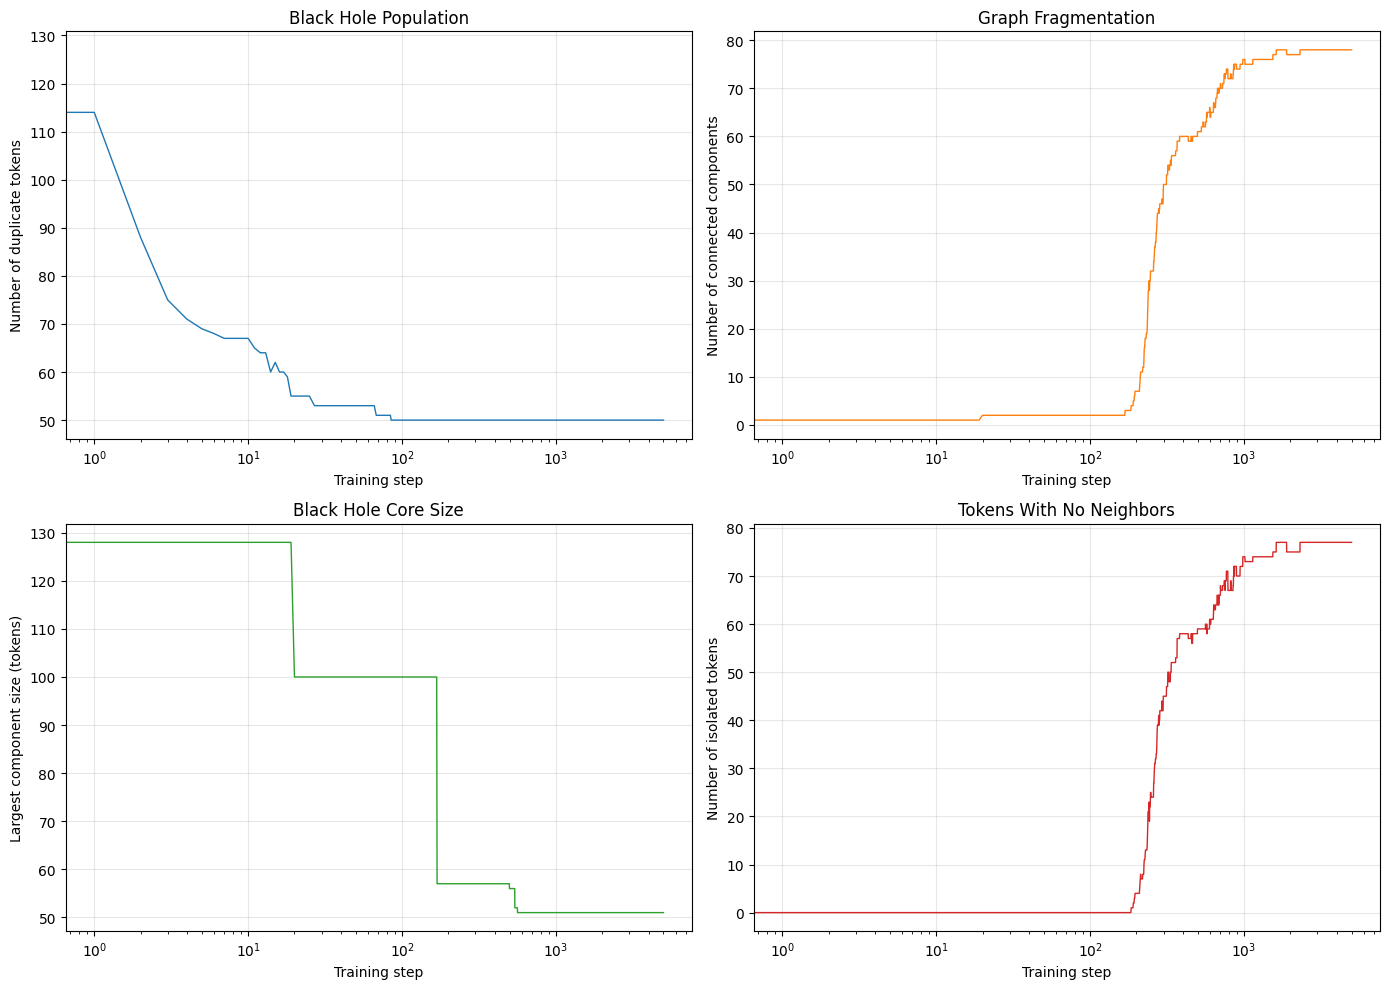


✓ Cluster dynamics visualization complete


In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

steps_np = steps.numpy()

# Panel 1: Duplicate tokens (from geometric analysis)
ax = axes[0, 0]
ax.plot(steps_np, n_duplicate_tokens.numpy(), linewidth=1, color='C0')
ax.set_xlabel('Training step')
ax.set_xscale('log')
ax.set_ylabel('Number of duplicate tokens')
ax.set_title('Black Hole Population')
ax.grid(True, alpha=0.3)

# Panel 2: Number of connected components
ax = axes[0, 1]
ax.plot(steps_np, n_components.numpy(), linewidth=1, color='C1')
ax.set_xlabel('Training step')
ax.set_xscale('log')
ax.set_ylabel('Number of connected components')
ax.set_title('Graph Fragmentation')
ax.grid(True, alpha=0.3)

# Panel 3: Largest component size
ax = axes[1, 0]
ax.plot(steps_np, largest_component_size.numpy(), linewidth=1, color='C2')
ax.set_xlabel('Training step')
ax.set_xscale('log')
ax.set_ylabel('Largest component size (tokens)')
ax.set_title('Black Hole Core Size')
ax.grid(True, alpha=0.3)

# Panel 4: Isolated tokens
ax = axes[1, 1]
ax.plot(steps_np, n_isolated_tokens.numpy(), linewidth=1, color='C3')
ax.set_xlabel('Training step')
ax.set_xscale('log')
ax.set_ylabel('Number of isolated tokens')
ax.set_title('Tokens With No Neighbors')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Cluster dynamics visualization complete")

## Component Size Distributions at Key Snapshots

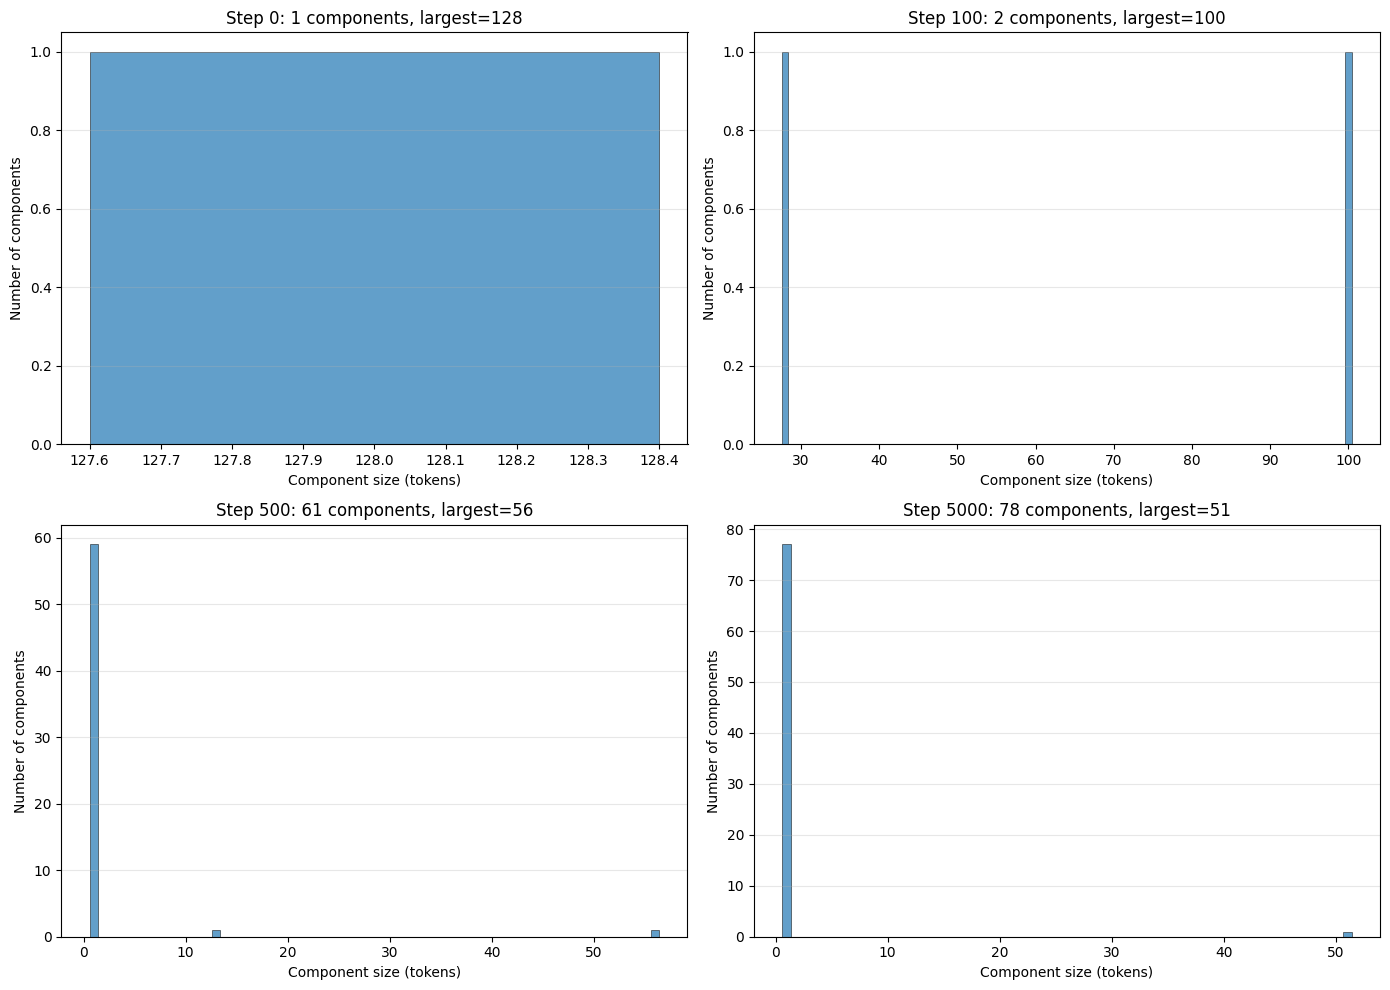


✓ Component size distributions plotted


In [35]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

for idx, step in enumerate(KEY_SNAPSHOTS):
    ax = axes[idx // 2, idx % 2]
    
    components = components_at_snapshots[step]
    sizes = [len(c) for c in components]
    size_counts = Counter(sizes)
    
    # Plot histogram
    if size_counts:
        x = sorted(size_counts.keys())
        y = [size_counts[size] for size in x]
        
        ax.bar(x, y, color='C0', alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.set_xlabel('Component size (tokens)')
        ax.set_ylabel('Number of components')
        ax.set_title(f'Step {step}: {len(components)} components, largest={max(sizes)}')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Log scale for y if needed
        if max(y) > 100:
            ax.set_yscale('log')
    else:
        ax.text(0.5, 0.5, 'No components', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Step {step}')

plt.tight_layout()
plt.show()

print("\n✓ Component size distributions plotted")

## Black Hole Membership at Key Snapshots

Show which tokens are in the largest connected component (the black hole core).

In [36]:
def format_token_list(token_ids, max_display=40):
    """Format token IDs as [byte, 'char'] pairs."""
    tokens = []
    for token_id in token_ids[:max_display]:
        if 32 <= token_id < 127:  # Printable ASCII
            tokens.append(f"[{token_id:3d}, '{chr(token_id)}']")
        else:
            tokens.append(f"[{token_id:3d}, '\\x{token_id:02x}']")
    
    result = ", ".join(tokens)
    if len(token_ids) > max_display:
        result += f"\n  ... and {len(token_ids) - max_display} more tokens"
    return result

print(f"\n{'='*80}")
print("BLACK HOLE MEMBERSHIP AT KEY SNAPSHOTS")
print(f"{'='*80}\n")

for step in KEY_SNAPSHOTS:
    components = components_at_snapshots[step]
    
    # Find components with size > 1 (clusters)
    clusters = [c for c in components if len(c) > 1]
    
    print(f"Step {step}:")
    print(f"  Total components: {len(components)}")
    print(f"  Clusters (size > 1): {len(clusters)}")
    
    if clusters:
        # Show largest component
        largest = clusters[0]
        print(f"\n  Largest component ({len(largest)} tokens):")
        print(f"    {format_token_list(sorted(largest))}")
        
        # Show other clusters if any
        if len(clusters) > 1:
            print(f"\n  Other clusters:")
            for i, cluster in enumerate(clusters[1:6], start=2):  # Show up to 5 more
                print(f"    Cluster {i} ({len(cluster)} tokens): {format_token_list(sorted(cluster))}")
            
            if len(clusters) > 6:
                print(f"    ... and {len(clusters) - 6} more clusters")
    else:
        print(f"  No clusters found (all tokens isolated)")
    
    print(f"\n{'-'*80}\n")

print(f"{'='*80}")


BLACK HOLE MEMBERSHIP AT KEY SNAPSHOTS

Step 0:
  Total components: 1
  Clusters (size > 1): 1

  Largest component (128 tokens):
    [  0, '\x00'], [  1, '\x01'], [  2, '\x02'], [  3, '\x03'], [  4, '\x04'], [  5, '\x05'], [  6, '\x06'], [  7, '\x07'], [  8, '\x08'], [  9, '\x09'], [ 10, '\x0a'], [ 11, '\x0b'], [ 12, '\x0c'], [ 13, '\x0d'], [ 14, '\x0e'], [ 15, '\x0f'], [ 16, '\x10'], [ 17, '\x11'], [ 18, '\x12'], [ 19, '\x13'], [ 20, '\x14'], [ 21, '\x15'], [ 22, '\x16'], [ 23, '\x17'], [ 24, '\x18'], [ 25, '\x19'], [ 26, '\x1a'], [ 27, '\x1b'], [ 28, '\x1c'], [ 29, '\x1d'], [ 30, '\x1e'], [ 31, '\x1f'], [ 32, ' '], [ 33, '!'], [ 34, '"'], [ 35, '#'], [ 36, '$'], [ 37, '%'], [ 38, '&'], [ 39, ''']
  ... and 88 more tokens

--------------------------------------------------------------------------------

Step 100:
  Total components: 2
  Clusters (size > 1): 2

  Largest component (100 tokens):
    [  0, '\x00'], [  1, '\x01'], [  2, '\x02'], [  3, '\x03'], [  4, '\x04'], [  5, '\x05